# ANALISIS PRODUKTIVITAS PEKERJA GARMEN
## Garments Worker Productivity Prediction

---

**Nama:** Yafa Nanda Putra  
**NIM:** 23.11.5555  
**Mata Kuliah:** Big Data & Data Mining (BDDM)  
**Tugas:** UAS

---

### Tujuan Analisis
Proyek ini bertujuan untuk:
1. Menganalisis faktor-faktor yang mempengaruhi produktivitas pekerja garmen
2. Membangun model prediksi produktivitas menggunakan Machine Learning
3. Memberikan rekomendasi untuk meningkatkan produktivitas

### Dataset
Dataset berisi informasi tentang produktivitas pekerja garmen dengan berbagai fitur seperti:
- Target produktivitas
- Waktu kerja (overtime, idle time)
- Karakteristik tim dan departemen
- Produktivitas aktual (target variable)

---

## Import Libraries
Import semua library yang dibutuhkan untuk analisis dan modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---

# PART 1: EXPLORATORY DATA ANALYSIS (EDA)

Pada bagian ini kita akan melakukan eksplorasi data untuk memahami:
- Struktur dan karakteristik dataset
- Distribusi data dan statistik deskriptif
- Missing values dan outliers
- Hubungan antar variabel

---

### 1.1 Data Loading & Understanding
Memuat dataset dan melihat informasi dasar tentang data

In [ ]:
# ============================================================================
# 1. DATA LOADING & UNDERSTANDING
# ============================================================================
print("\n[1] DATA LOADING & UNDERSTANDING")
print("-"*80)

df = pd.read_csv('/content/sample_data/garments_worker_productivity.csv')
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")



[1] DATA LOADING & UNDERSTANDING
--------------------------------------------------------------------------------
Jumlah baris: 1197
Jumlah kolom: 15


### 1.2 Kolom Dataset
Melihat daftar kolom yang tersedia dalam dataset

In [ ]:
print(f"\nKolom-kolom dalam dataset:")
print(df.columns.tolist())


Kolom-kolom dalam dataset:
['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']


### 1.3 Tipe Data
Mengecek tipe data setiap kolom (numerical vs categorical)

In [ ]:
print(f"\nTipe data:")
print(df.dtypes)


Tipe data:
date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


### 1.4 Statistik Deskriptif
Melihat rangkuman statistik untuk kolom numerical

### 2.2.1 Visualisasi Outliers
Melihat distribusi data dan outliers menggunakan boxplot

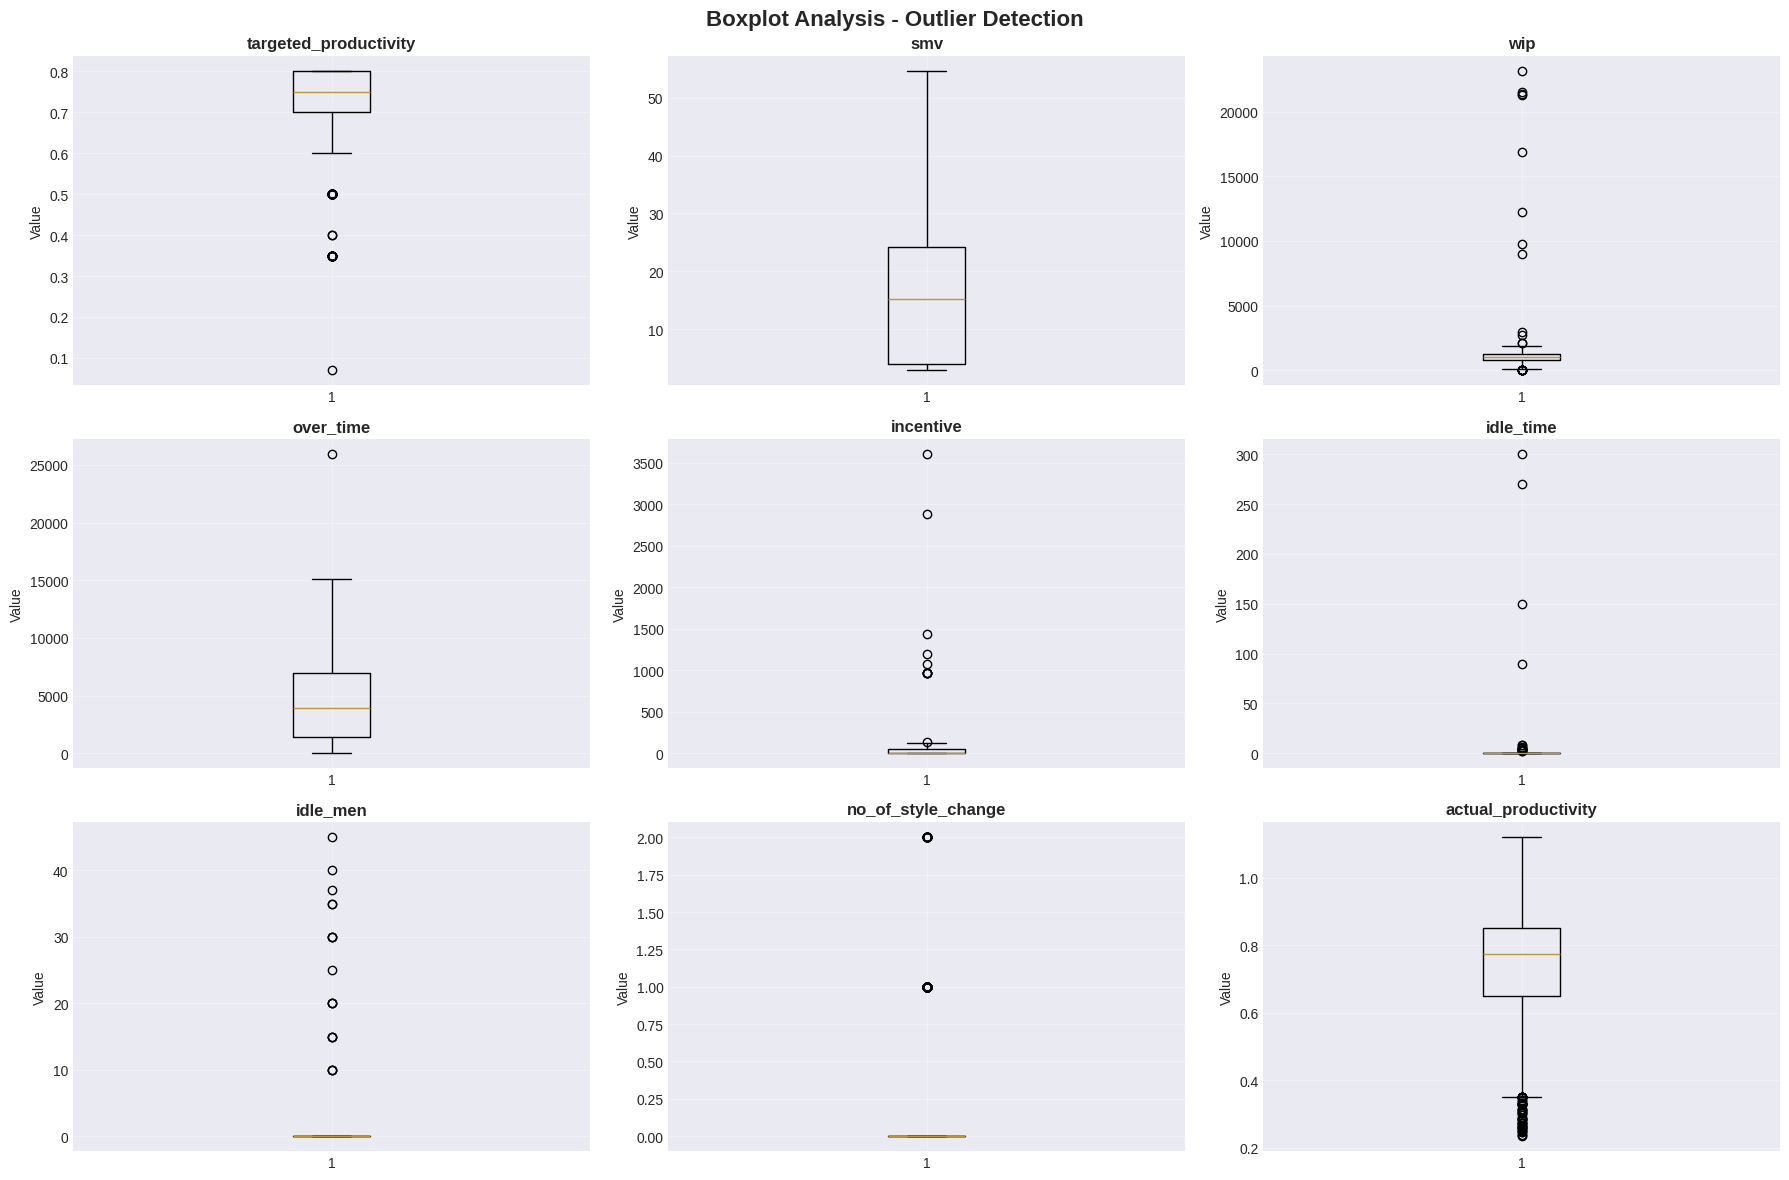

✓ Boxplot visualization completed


In [ ]:
# Visualisasi outliers dengan boxplot
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Boxplot Analysis - Outlier Detection', fontsize=16, fontweight='bold')

numeric_cols_plot = ['targeted_productivity', 'smv', 'wip', 'over_time',
                     'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'actual_productivity']

for idx, col in enumerate(numeric_cols_plot):
    ax = axes[idx // 3, idx % 3]
    ax.boxplot(df[col].dropna())
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Boxplot visualization completed")

### 2.2.2  Handling Outliers
Menangani outliers menggunakan **Capping Method** (Winsorization)  
Outliers akan dibatasi pada percentile ke-1 dan ke-99

In [ ]:
# Handling outliers dengan capping method
print("\n[2.2.2] Handling Outliers with Capping Method:")
print("-" * 80)

# Buat copy dataframe
df_no_outliers = df.copy()

# Kolom yang akan di-cap (exclude categorical)
cols_to_cap = ['targeted_productivity', 'smv', 'wip', 'over_time',
               'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'actual_productivity']

outliers_before = {}
outliers_after = {}

for col in cols_to_cap:
    # Hitung outliers sebelum capping
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_before[col] = ((df_no_outliers[col] < (Q1 - 1.5 * IQR)) |
                            (df_no_outliers[col] > (Q3 + 1.5 * IQR))).sum()

    # Capping pada percentile 1 dan 99
    lower_cap = df_no_outliers[col].quantile(0.01)
    upper_cap = df_no_outliers[col].quantile(0.99)

    df_no_outliers[col] = df_no_outliers[col].clip(lower=lower_cap, upper=upper_cap)

    # Hitung outliers setelah capping
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_after[col] = ((df_no_outliers[col] < (Q1 - 1.5 * IQR)) |
                           (df_no_outliers[col] > (Q3 + 1.5 * IQR))).sum()

# Tampilkan hasil
outlier_comparison = pd.DataFrame({
    'Feature': cols_to_cap,
    'Outliers_Before': [outliers_before[col] for col in cols_to_cap],
    'Outliers_After': [outliers_after[col] for col in cols_to_cap],
    'Reduced': [outliers_before[col] - outliers_after[col] for col in cols_to_cap]
})

print("\nOutlier Handling Results:")
print(outlier_comparison.to_string(index=False))
print(f"\n✓ Total outliers reduced: {outlier_comparison['Reduced'].sum()}")

# Update dataframe utama
df = df_no_outliers.copy()
print("\n✓ Outliers handled successfully!")


[2.2.2] Handling Outliers with Capping Method:
--------------------------------------------------------------------------------

Outlier Handling Results:
              Feature  Outliers_Before  Outliers_After  Reduced
targeted_productivity               79              79        0
                  smv                0               0        0
                  wip               22              22        0
            over_time                1               0        1
            incentive               11               0       11
            idle_time               18              18        0
             idle_men               18              18        0
   no_of_style_change              147             147        0
  actual_productivity               54              54        0

✓ Total outliers reduced: 12

✓ Outliers handled successfully!


In [ ]:
print(f"\nStatistik deskriptif:")
print(df.describe())


Statistik deskriptif:
              team  targeted_productivity          smv          wip  \
count  1197.000000            1197.000000  1197.000000   691.000000   
mean      6.426901               0.729866    15.000292  1099.825181   
std       3.463963               0.096640    10.762673   940.081248   
min       1.000000               0.350000     2.900000    27.600000   
25%       3.000000               0.700000     3.940000   774.500000   
50%       6.000000               0.750000    15.260000  1039.000000   
75%       9.000000               0.800000    24.260000  1252.500000   
max      12.000000               0.800000    42.970000  9072.000000   

          over_time    incentive    idle_time     idle_men  \
count   1197.000000  1197.000000  1197.000000  1197.000000   
mean    4533.350042    26.657477     0.055556     0.215038   
std     3244.467766    31.396264     0.456334     1.757004   
min        0.000000     0.000000     0.000000     0.000000   
25%     1440.000000     0.0

### 1.5 ℹ Info Dataset
Informasi lengkap tentang dataset termasuk memory usage

In [ ]:
print(f"\nInfo dataset:")
print(df.info())


Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   float64
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   fl

---

# PART 2: DATA PREPROCESSING

Preprocessing adalah tahap penting untuk mempersiapkan data sebelum modeling. Tahapan meliputi:
- Menangani missing values
- Deteksi outliers
- Feature engineering (membuat fitur baru)
- Feature selection (memilih fitur yang relevan)

---

---

# PART 3.5: ADDITIONAL EDA - VISUAL ANALYSIS

Analisis visual lebih mendalam untuk memahami pola dan hubungan dalam data

---

### 3.5.1 Distribusi Numerical Features
Melihat distribusi setiap numerical feature

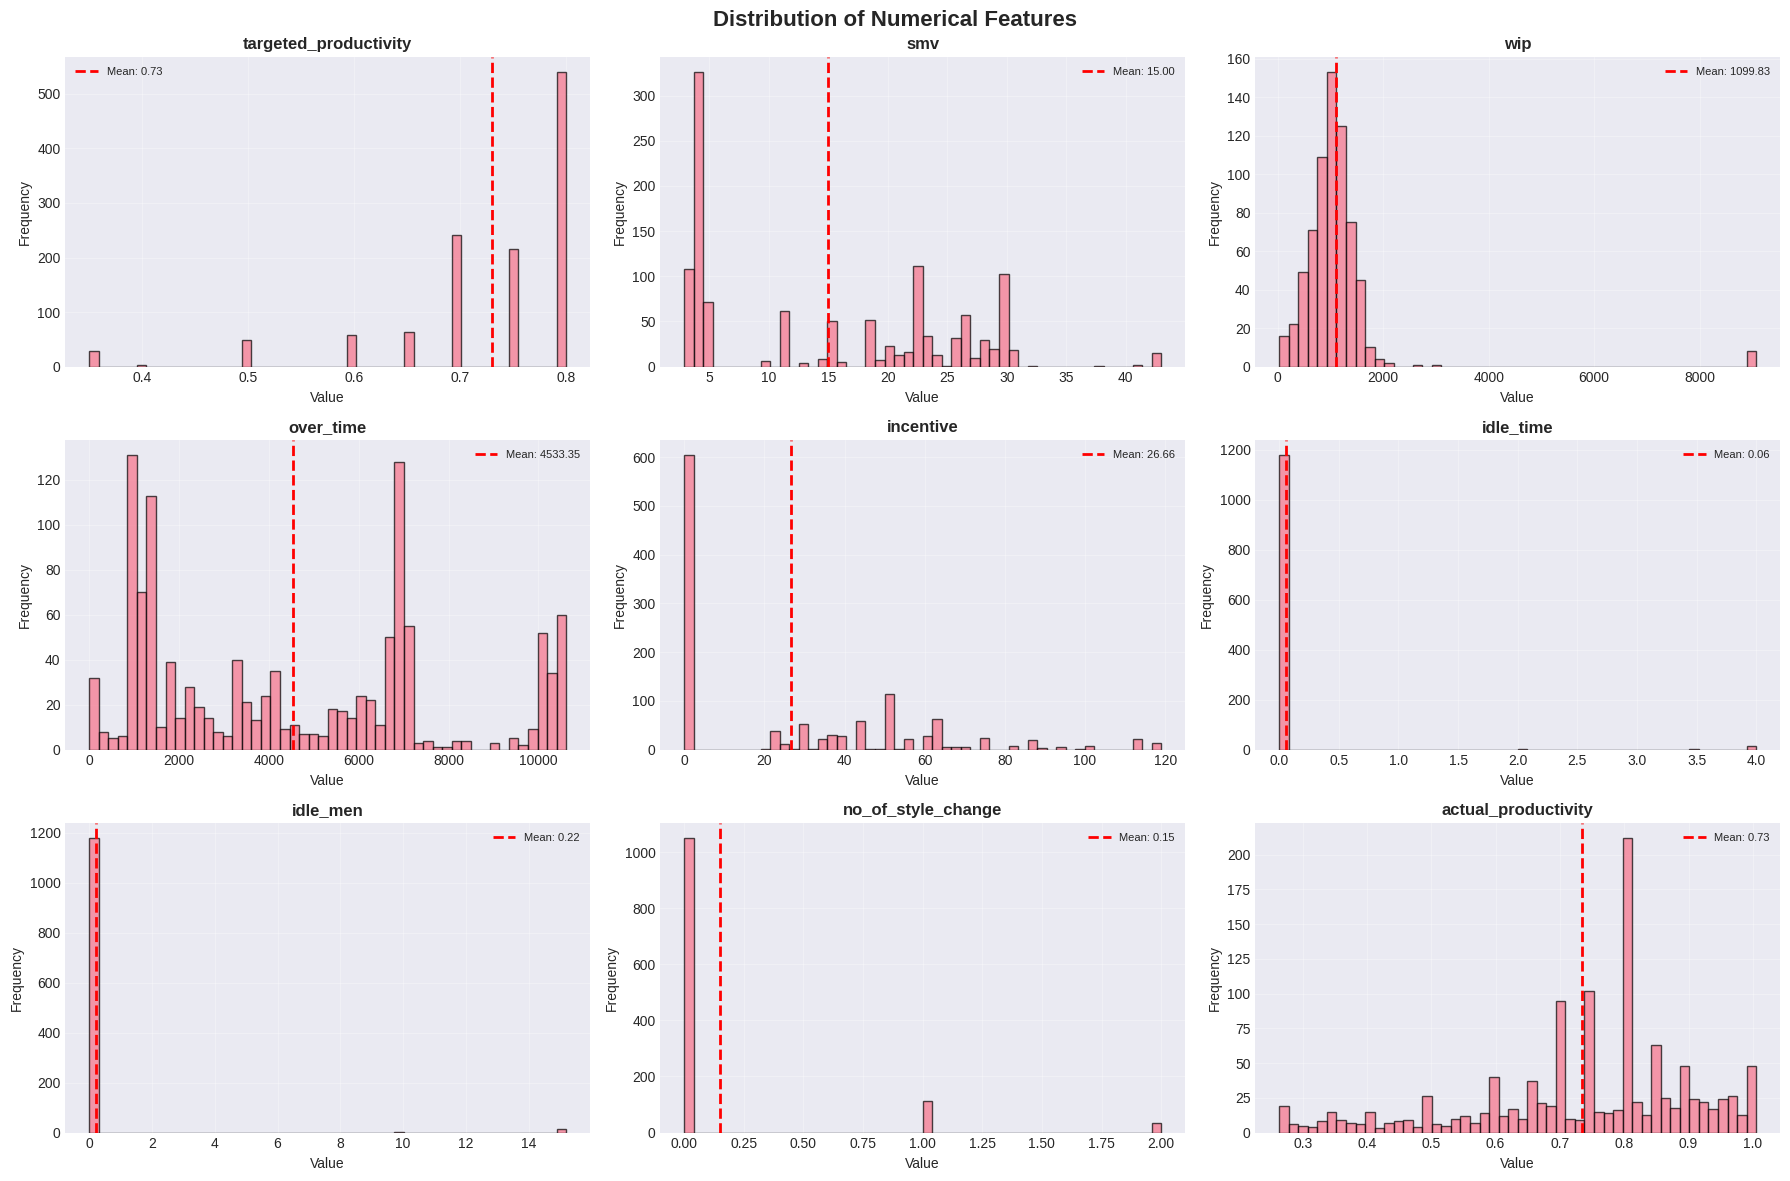

In [ ]:
# Distribusi numerical features
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')

numerical_features = ['targeted_productivity', 'smv', 'wip', 'over_time',
                      'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'actual_productivity']

for idx, col in enumerate(numerical_features):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5.2 Produktivitas per Departemen
Analisis perbandingan produktivitas antara departemen

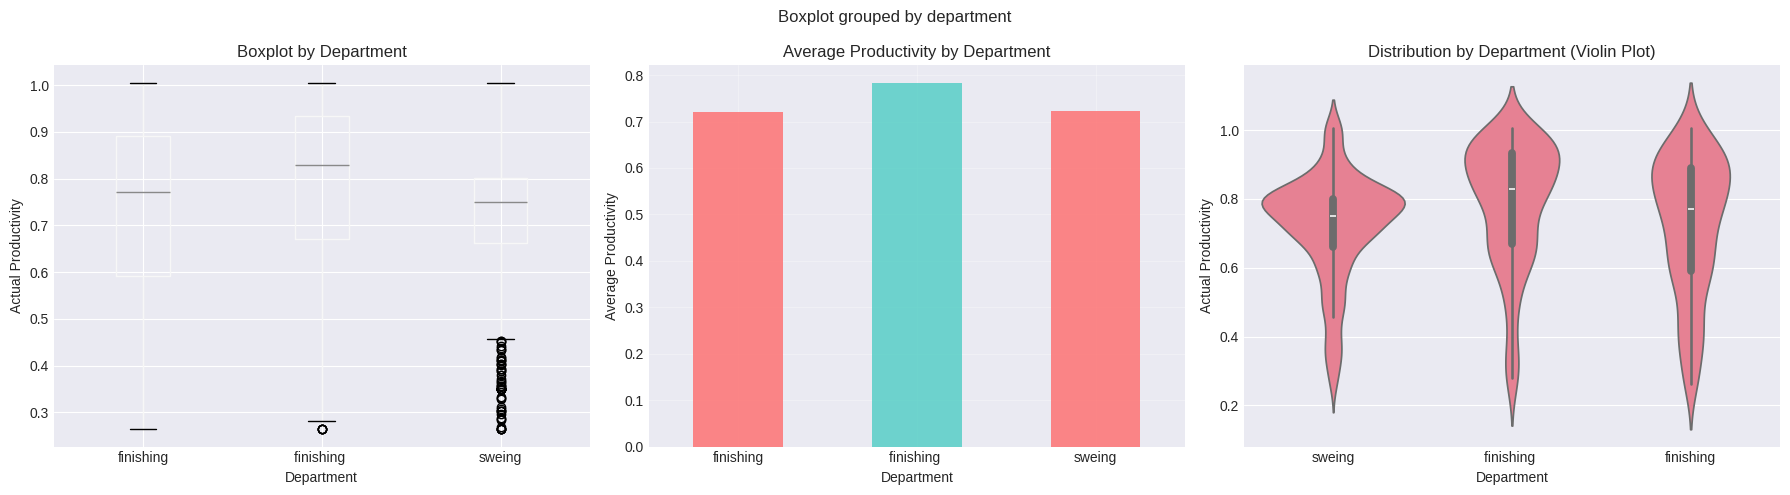


Statistik Produktivitas per Departemen:
                mean       std  count
department                           
finishing   0.721218  0.200111    249
finishing   0.782007  0.185231    257
sweing      0.721895  0.154100    691


In [ ]:
# Analisis produktivitas per departemen
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Productivity Analysis by Department', fontsize=16, fontweight='bold')

# Boxplot
df.boxplot(column='actual_productivity', by='department', ax=axes[0])
axes[0].set_title('Boxplot by Department')
axes[0].set_xlabel('Department')
axes[0].set_ylabel('Actual Productivity')
plt.sca(axes[0])
plt.xticks(rotation=0)

# Bar plot - rata-rata
dept_prod = df.groupby('department')['actual_productivity'].agg(['mean', 'std', 'count'])
dept_prod['mean'].plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
axes[1].set_title('Average Productivity by Department')
axes[1].set_xlabel('Department')
axes[1].set_ylabel('Average Productivity')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3)

# Violin plot
import seaborn as sns
sns.violinplot(data=df, x='department', y='actual_productivity', ax=axes[2])
axes[2].set_title('Distribution by Department (Violin Plot)')
axes[2].set_xlabel('Department')
axes[2].set_ylabel('Actual Productivity')

plt.tight_layout()
plt.show()

print("\nStatistik Produktivitas per Departemen:")
print(dept_prod)

### 3.5.3 Produktivitas per Team
Analisis performa setiap team

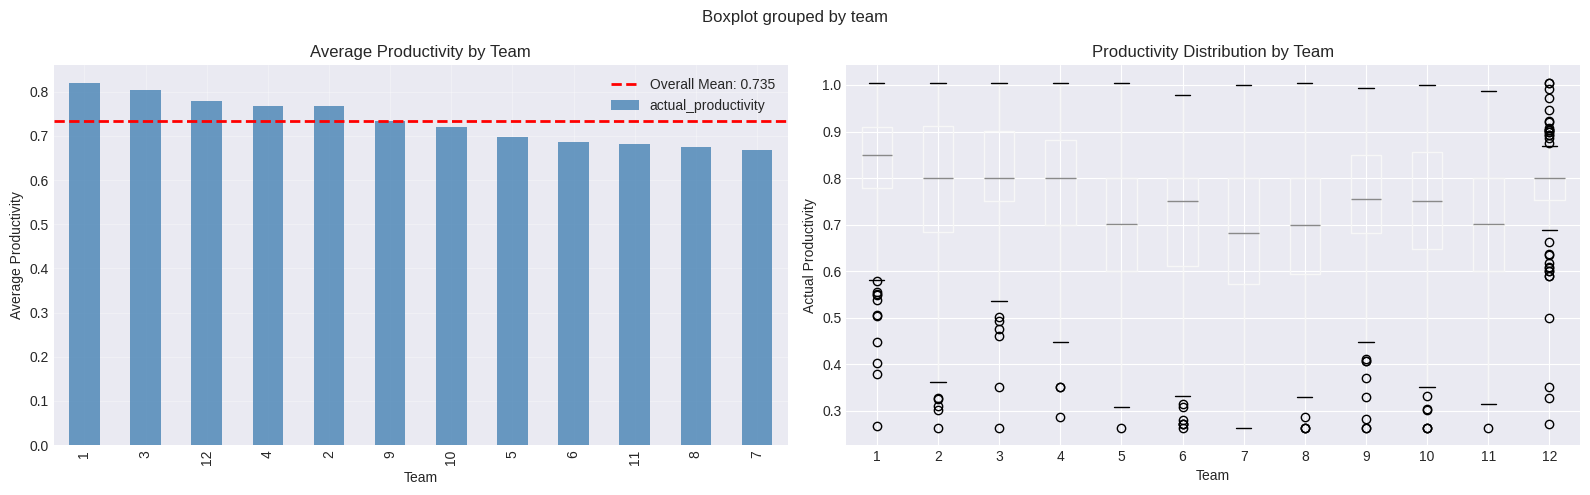


Top 5 Teams by Productivity:
team
1     0.819049
3     0.803381
12    0.778905
4     0.768897
2     0.768744
Name: actual_productivity, dtype: float64

Bottom 5 Teams by Productivity:
team
5     0.697997
6     0.685385
11    0.682033
8     0.674225
7     0.668064
Name: actual_productivity, dtype: float64


In [ ]:
# Analisis produktivitas per team
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Productivity Analysis by Team', fontsize=16, fontweight='bold')

# Bar plot
team_prod = df.groupby('team')['actual_productivity'].mean().sort_values(ascending=False)
team_prod.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Average Productivity by Team')
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Average Productivity')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(df['actual_productivity'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Overall Mean: {df["actual_productivity"].mean():.3f}')
axes[0].legend()

# Boxplot
df.boxplot(column='actual_productivity', by='team', ax=axes[1])
axes[1].set_title('Productivity Distribution by Team')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Actual Productivity')

plt.tight_layout()
plt.show()

print("\nTop 5 Teams by Productivity:")
print(team_prod.head())
print("\nBottom 5 Teams by Productivity:")
print(team_prod.tail())

### 3.5.4 Produktivitas per Quarter & Day
Analisis temporal productivity

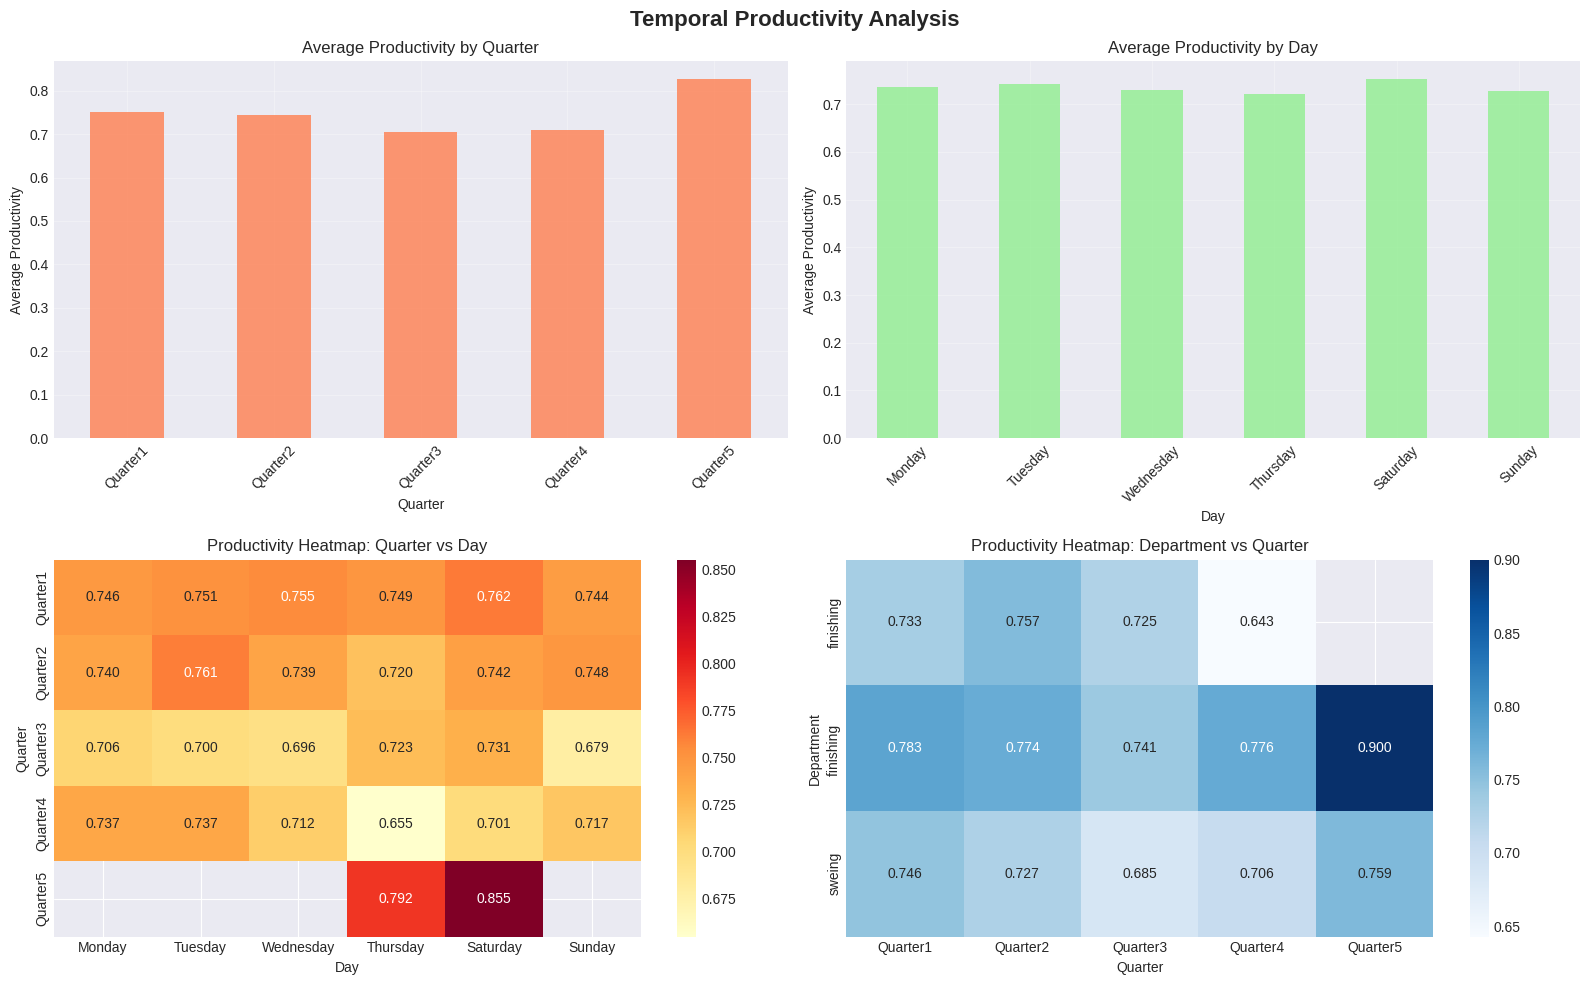


Produktivitas per Quarter:
quarter
Quarter1    0.751297
Quarter2    0.743132
Quarter3    0.703902
Quarter4    0.708874
Quarter5    0.826177
Name: actual_productivity, dtype: float64

Produktivitas per Day:
day
Monday       0.735078
Tuesday      0.742560
Wednesday    0.730230
Thursday     0.721924
Saturday     0.751835
Sunday       0.727634
Name: actual_productivity, dtype: float64


In [ ]:
# Analisis produktivitas per quarter dan day
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temporal Productivity Analysis', fontsize=16, fontweight='bold')

# Quarter analysis
quarter_prod = df.groupby('quarter')['actual_productivity'].mean().sort_index()
quarter_prod.plot(kind='bar', ax=axes[0, 0], color='coral', alpha=0.8)
axes[0, 0].set_title('Average Productivity by Quarter')
axes[0, 0].set_xlabel('Quarter')
axes[0, 0].set_ylabel('Average Productivity')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Day analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday']
day_prod = df.groupby('day')['actual_productivity'].mean().reindex(day_order)
day_prod.plot(kind='bar', ax=axes[0, 1], color='lightgreen', alpha=0.8)
axes[0, 1].set_title('Average Productivity by Day')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Average Productivity')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Heatmap: Quarter vs Day
pivot_quarter_day = df.pivot_table(values='actual_productivity',
                                    index='quarter', columns='day', aggfunc='mean')
pivot_quarter_day = pivot_quarter_day[day_order]  # Reorder columns
sns.heatmap(pivot_quarter_day, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Productivity Heatmap: Quarter vs Day')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Quarter')

# Heatmap: Department vs Quarter
pivot_dept_quarter = df.pivot_table(values='actual_productivity',
                                     index='department', columns='quarter', aggfunc='mean')
sns.heatmap(pivot_dept_quarter, annot=True, fmt='.3f', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Productivity Heatmap: Department vs Quarter')
axes[1, 1].set_xlabel('Quarter')
axes[1, 1].set_ylabel('Department')

plt.tight_layout()
plt.show()

print("\nProduktivitas per Quarter:")
print(quarter_prod)
print("\nProduktivitas per Day:")
print(day_prod)

### 3.5.5 Impact Analysis: Overtime & Incentive
Analisis pengaruh overtime dan incentive terhadap produktivitas

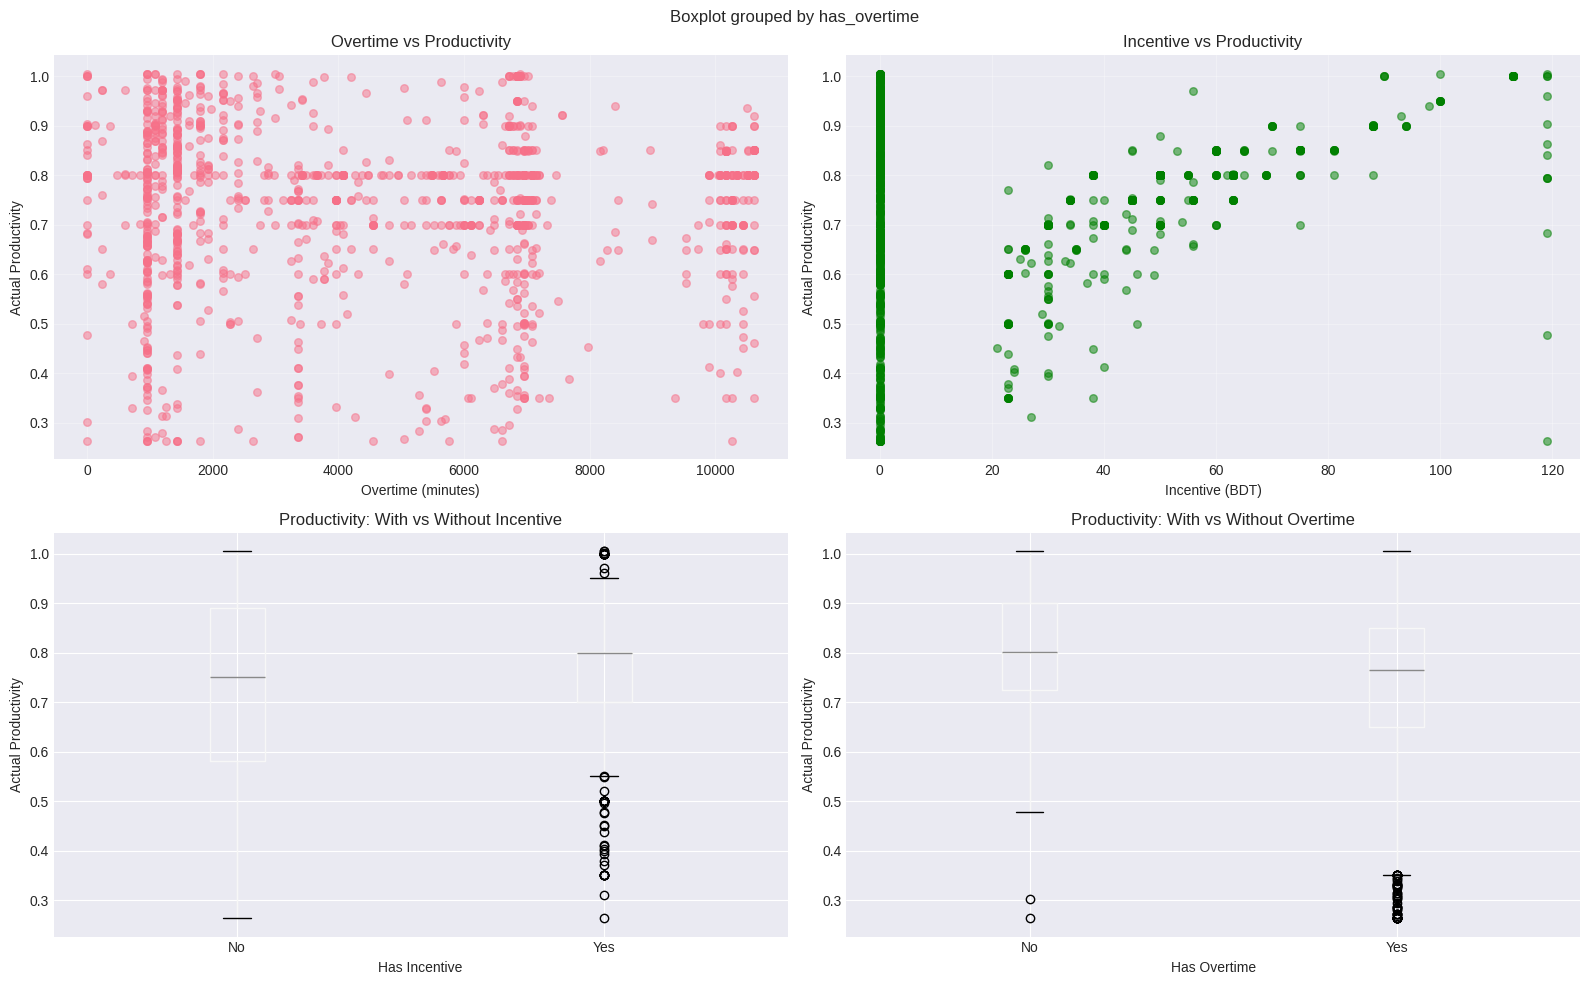


Produktivitas dengan/tanpa Incentive:
               count      mean       std       min       25%       50%  \
has_incentive                                                            
False          604.0  0.711961  0.207847  0.263593  0.580848  0.750507   
True           593.0  0.757781  0.124359  0.264062  0.700505  0.800003   

                    75%       max  
has_incentive                      
False          0.890842  1.005156  
True           0.800594  1.005156  

Produktivitas dengan/tanpa Overtime:
               count      mean       std       min       25%       50%  \
has_overtime                                                             
False           31.0  0.783496  0.181986  0.264062  0.725626  0.800779   
True          1166.0  0.733362  0.172744  0.263593  0.650241  0.766111   

                   75%       max  
has_overtime                      
False         0.900471  1.005156  
True          0.850137  1.005156  


In [ ]:
# Impact analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Impact of Overtime and Incentive on Productivity', fontsize=16, fontweight='bold')

# Overtime vs Productivity
axes[0, 0].scatter(df['over_time'], df['actual_productivity'], alpha=0.5, s=30)
axes[0, 0].set_xlabel('Overtime (minutes)')
axes[0, 0].set_ylabel('Actual Productivity')
axes[0, 0].set_title('Overtime vs Productivity')
axes[0, 0].grid(True, alpha=0.3)

# Incentive vs Productivity
axes[0, 1].scatter(df['incentive'], df['actual_productivity'], alpha=0.5, s=30, color='green')
axes[0, 1].set_xlabel('Incentive (BDT)')
axes[0, 1].set_ylabel('Actual Productivity')
axes[0, 1].set_title('Incentive vs Productivity')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot: Productivity by Incentive Status
df['has_incentive'] = df['incentive'] > 0
df.boxplot(column='actual_productivity', by='has_incentive', ax=axes[1, 0])
axes[1, 0].set_title('Productivity: With vs Without Incentive')
axes[1, 0].set_xlabel('Has Incentive')
axes[1, 0].set_ylabel('Actual Productivity')
axes[1, 0].set_xticklabels(['No', 'Yes'])

# Boxplot: Productivity by Overtime Status
df['has_overtime'] = df['over_time'] > 0
df.boxplot(column='actual_productivity', by='has_overtime', ax=axes[1, 1])
axes[1, 1].set_title('Productivity: With vs Without Overtime')
axes[1, 1].set_xlabel('Has Overtime')
axes[1, 1].set_ylabel('Actual Productivity')
axes[1, 1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# Statistics
print("\nProduktivitas dengan/tanpa Incentive:")
print(df.groupby('has_incentive')['actual_productivity'].describe())
print("\nProduktivitas dengan/tanpa Overtime:")
print(df.groupby('has_overtime')['actual_productivity'].describe())

### 2.1 Missing Values Analysis
Mengidentifikasi dan menangani nilai yang hilang dalam dataset

In [ ]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n\n[2] DATA PREPROCESSING")
print("-"*80)

# 2.1 Menangani Missing Values
print("\n[2.1] Missing Values Analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing_Count'] > 0])

# Handle missing values
# WIP memiliki missing values, kita akan imputasi dengan median
if df['wip'].isnull().sum() > 0:
    df['wip'].fillna(df['wip'].median(), inplace=True)
    print(f"\nMissing values pada 'wip' diimputasi dengan median: {df['wip'].median()}")



[2] DATA PREPROCESSING
--------------------------------------------------------------------------------

[2.1] Missing Values Analysis:
     Missing_Count  Percentage
wip            506   42.272348

Missing values pada 'wip' diimputasi dengan median: 1039.0


### 2.2 Outlier Detection
Mendeteksi outliers menggunakan metode IQR (Interquartile Range)

In [ ]:
# 2.2 Menangani Outliers
print("\n[2.2] Outlier Detection:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    outlier_summary[col] = outliers

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outliers_Count'])
print(outlier_df[outlier_df['Outliers_Count'] > 0])


[2.2] Outlier Detection:
                       Outliers_Count
targeted_productivity              79
wip                               358
idle_time                          18
idle_men                           18
no_of_style_change                147
actual_productivity                54


### 2.3 Feature Engineering
Membuat fitur-fitur baru dari data yang sudah ada:
- Ekstraksi informasi temporal (month, day_of_week)
- Encoding variabel kategorikal

In [ ]:
# 2.3 Feature Engineering
print("\n[2.3] Feature Engineering:")

# Membuat salinan dataframe
df_processed = df.copy()

# Extract informasi dari date
df_processed['date'] = pd.to_datetime(df_processed['date'])
df_processed['month'] = df_processed['date'].dt.month
df_processed['day_of_week'] = df_processed['date'].dt.dayofweek

# Encoding categorical variables
print("\nEncoding categorical variables...")
le_department = LabelEncoder()
le_day = LabelEncoder()
le_quarter = LabelEncoder()

df_processed['department_encoded'] = le_department.fit_transform(df_processed['department'].str.strip())
df_processed['day_encoded'] = le_day.fit_transform(df_processed['day'])
df_processed['quarter_encoded'] = le_quarter.fit_transform(df_processed['quarter'])

print(f"Department classes: {le_department.classes_}")
print(f"Day classes: {le_day.classes_}")
print(f"Quarter classes: {le_quarter.classes_}")


[2.3] Feature Engineering:

Encoding categorical variables...
Department classes: ['finishing' 'sweing']
Day classes: ['Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']
Quarter classes: ['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']


### 2.4 Feature Selection
Memilih fitur-fitur yang akan digunakan untuk modeling

In [ ]:
# 2.4 Feature Selection
print("\n[2.4] Feature Selection:")
features = ['quarter_encoded', 'department_encoded', 'day_encoded', 'team',
            'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive',
            'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers',
            'month', 'day_of_week']

target = 'actual_productivity'

X = df_processed[features]
y = df_processed[target]

print(f"Features yang digunakan: {features}")
print(f"Target variable: {target}")
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")


[2.4] Feature Selection:
Features yang digunakan: ['quarter_encoded', 'department_encoded', 'day_encoded', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'month', 'day_of_week']
Target variable: actual_productivity

Shape X: (1197, 15)
Shape y: (1197,)


---

# PART 3: DATA SPLITTING

Membagi dataset menjadi training set dan testing set dengan rasio 80:20

---

In [ ]:

# ============================================================================
# 3. DATA SPLITTING
# ============================================================================
print("\n\n[3] DATA SPLITTING")
print("-"*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set ratio: {X_train.shape[0]/len(X)*100:.2f}%")
print(f"Testing set ratio: {X_test.shape[0]/len(X)*100:.2f}%")



[3] DATA SPLITTING
--------------------------------------------------------------------------------
Training set size: 957 samples
Testing set size: 240 samples
Training set ratio: 79.95%
Testing set ratio: 20.05%


---

# PART 4: FEATURE SCALING

Normalisasi fitur menggunakan StandardScaler agar semua fitur memiliki skala yang sama.
Ini penting untuk algoritma yang sensitif terhadap skala data.

---

In [ ]:
# ============================================================================
# 4. FEATURE SCALING
# ============================================================================
print("\n\n[4] FEATURE SCALING")
print("-"*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling menggunakan StandardScaler")
print(f"Mean setelah scaling (train): {X_train_scaled.mean():.6f}")
print(f"Std setelah scaling (train): {X_train_scaled.std():.6f}")



[4] FEATURE SCALING
--------------------------------------------------------------------------------
Feature scaling menggunakan StandardScaler
Mean setelah scaling (train): -0.000000
Std setelah scaling (train): 1.000000


---

# PART 5: MODEL BUILDING & TRAINING

Pada bagian ini kita akan membangun dan melatih beberapa model:
1. **Linear Regression** - Model baseline sederhana
2. **Random Forest Regression** - Model ensemble yang lebih kompleks
3. **Hyperparameter Tuning** - Optimasi parameter untuk performa terbaik

---

In [ ]:

# ============================================================================
# 5. MODEL BUILDING & TRAINING
# ============================================================================
print("\n\n[5] MODEL BUILDING & TRAINING")
print("-"*80)

# 5.1 Linear Regression
print("\n[5.1] Linear Regression:")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("✓ Linear Regression model trained")

# 5.2 Random Forest Regression
print("\n[5.2] Random Forest Regression:")
print("Training with initial parameters...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
print("✓ Random Forest model trained")

# 5.3 Hyperparameter Tuning for Random Forest
print("\n[5.3] Hyperparameter Tuning (Random Forest):")
print("Performing GridSearchCV...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

rf_grid.fit(X_train_scaled, y_train)
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best cross-validation R² score: {rf_grid.best_score_:.4f}")

# Update model dengan parameter terbaik
rf_model_tuned = rf_grid.best_estimator_



[5] MODEL BUILDING & TRAINING
--------------------------------------------------------------------------------

[5.1] Linear Regression:
✓ Linear Regression model trained

[5.2] Random Forest Regression:
Training with initial parameters...
✓ Random Forest model trained

[5.3] Hyperparameter Tuning (Random Forest):
Performing GridSearchCV...
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation R² score: 0.4762


---

# PART 6: MODEL EVALUATION

Evaluasi performa model menggunakan berbagai metrik:
- **R² Score**: Seberapa baik model menjelaskan variasi data
- **RMSE**: Root Mean Squared Error
- **MAE**: Mean Absolute Error
- **MAPE**: Mean Absolute Percentage Error
- **Cross-Validation**: Validasi silang untuk mengukur generalisasi model

---

In [ ]:
# ============================================================================
# 6. MODEL EVALUATION
# ============================================================================
print("\n\n[6] MODEL EVALUATION")
print("-"*80)

# Prediksi
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)

rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

rf_tuned_pred_train = rf_model_tuned.predict(X_train_scaled)
rf_tuned_pred_test = rf_model_tuned.predict(X_test_scaled)

# Fungsi untuk menghitung metrics
def calculate_metrics(y_true, y_pred, model_name, dataset_type):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'Model': model_name,
        'Dataset': dataset_type,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

# Hitung metrics untuk semua model
metrics_list = []

# Linear Regression
metrics_list.append(calculate_metrics(y_train, lr_pred_train, 'Linear Regression', 'Train'))
metrics_list.append(calculate_metrics(y_test, lr_pred_test, 'Linear Regression', 'Test'))

# Random Forest (Initial)
metrics_list.append(calculate_metrics(y_train, rf_pred_train, 'Random Forest', 'Train'))
metrics_list.append(calculate_metrics(y_test, rf_pred_test, 'Random Forest', 'Test'))

# Random Forest (Tuned)
metrics_list.append(calculate_metrics(y_train, rf_tuned_pred_train, 'Random Forest (Tuned)', 'Train'))
metrics_list.append(calculate_metrics(y_test, rf_tuned_pred_test, 'Random Forest (Tuned)', 'Test'))

# Buat DataFrame metrics
metrics_df = pd.DataFrame(metrics_list)

print("\n[6.1] Performance Metrics:")
print(metrics_df.to_string(index=False))

# Cross-validation scores
print("\n[6.2] Cross-Validation Scores (5-Fold):")
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
rf_cv_scores = cross_val_score(rf_model_tuned, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"Linear Regression CV R² scores: {lr_cv_scores}")
print(f"Linear Regression Mean CV R²: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")
print(f"\nRandom Forest CV R² scores: {rf_cv_scores}")
print(f"Random Forest Mean CV R²: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")



[6] MODEL EVALUATION
--------------------------------------------------------------------------------

[6.1] Performance Metrics:
                Model Dataset      MSE     RMSE      MAE       R²      MAPE
    Linear Regression   Train 0.019644 0.140158 0.100296 0.361643 17.705491
    Linear Regression    Test 0.017770 0.133304 0.094407 0.328308 15.864197
        Random Forest   Train 0.005050 0.071062 0.042697 0.835902  7.818548
        Random Forest    Test 0.011957 0.109346 0.069419 0.548052 11.500370
Random Forest (Tuned)   Train 0.006741 0.082105 0.050223 0.780936  9.159136
Random Forest (Tuned)    Test 0.011976 0.109434 0.070115 0.547322 11.650893

[6.2] Cross-Validation Scores (5-Fold):
Linear Regression CV R² scores: [0.25974429 0.22211697 0.37987965 0.36263176 0.3847305 ]
Linear Regression Mean CV R²: 0.3218 (+/- 0.1350)

Random Forest CV R² scores: [0.33842414 0.4127361  0.54547642 0.52664217 0.55771301]
Random Forest Mean CV R²: 0.4762 (+/- 0.1720)


---

# PART 7: FEATURE IMPORTANCE ANALYSIS

Menganalisis fitur mana yang paling berpengaruh terhadap prediksi produktivitas.
Ini membantu kita memahami faktor-faktor kunci yang menentukan produktivitas pekerja.

---

In [ ]:
# ============================================================================
# 7. FEATURE IMPORTANCE (Random Forest)
# ============================================================================
print("\n\n[7] FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))



[7] FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

Top 10 Most Important Features:
              Feature  Importance
targeted_productivity    0.277894
                  smv    0.133139
            incentive    0.128443
        no_of_workers    0.098995
                 team    0.082147
            over_time    0.077704
      quarter_encoded    0.056999
                  wip    0.036095
          day_encoded    0.030926
          day_of_week    0.030136


---

# PART 8: VISUALISASI HASIL

Membuat berbagai visualisasi untuk memahami:
- Distribusi data dan outliers
- Korelasi antar fitur
- Perbandingan performa model
- Predicted vs Actual values
- Residual analysis

---



[8] GENERATING VISUALIZATIONS...
--------------------------------------------------------------------------------
✓ Comprehensive visualization saved: comprehensive_analysis.png


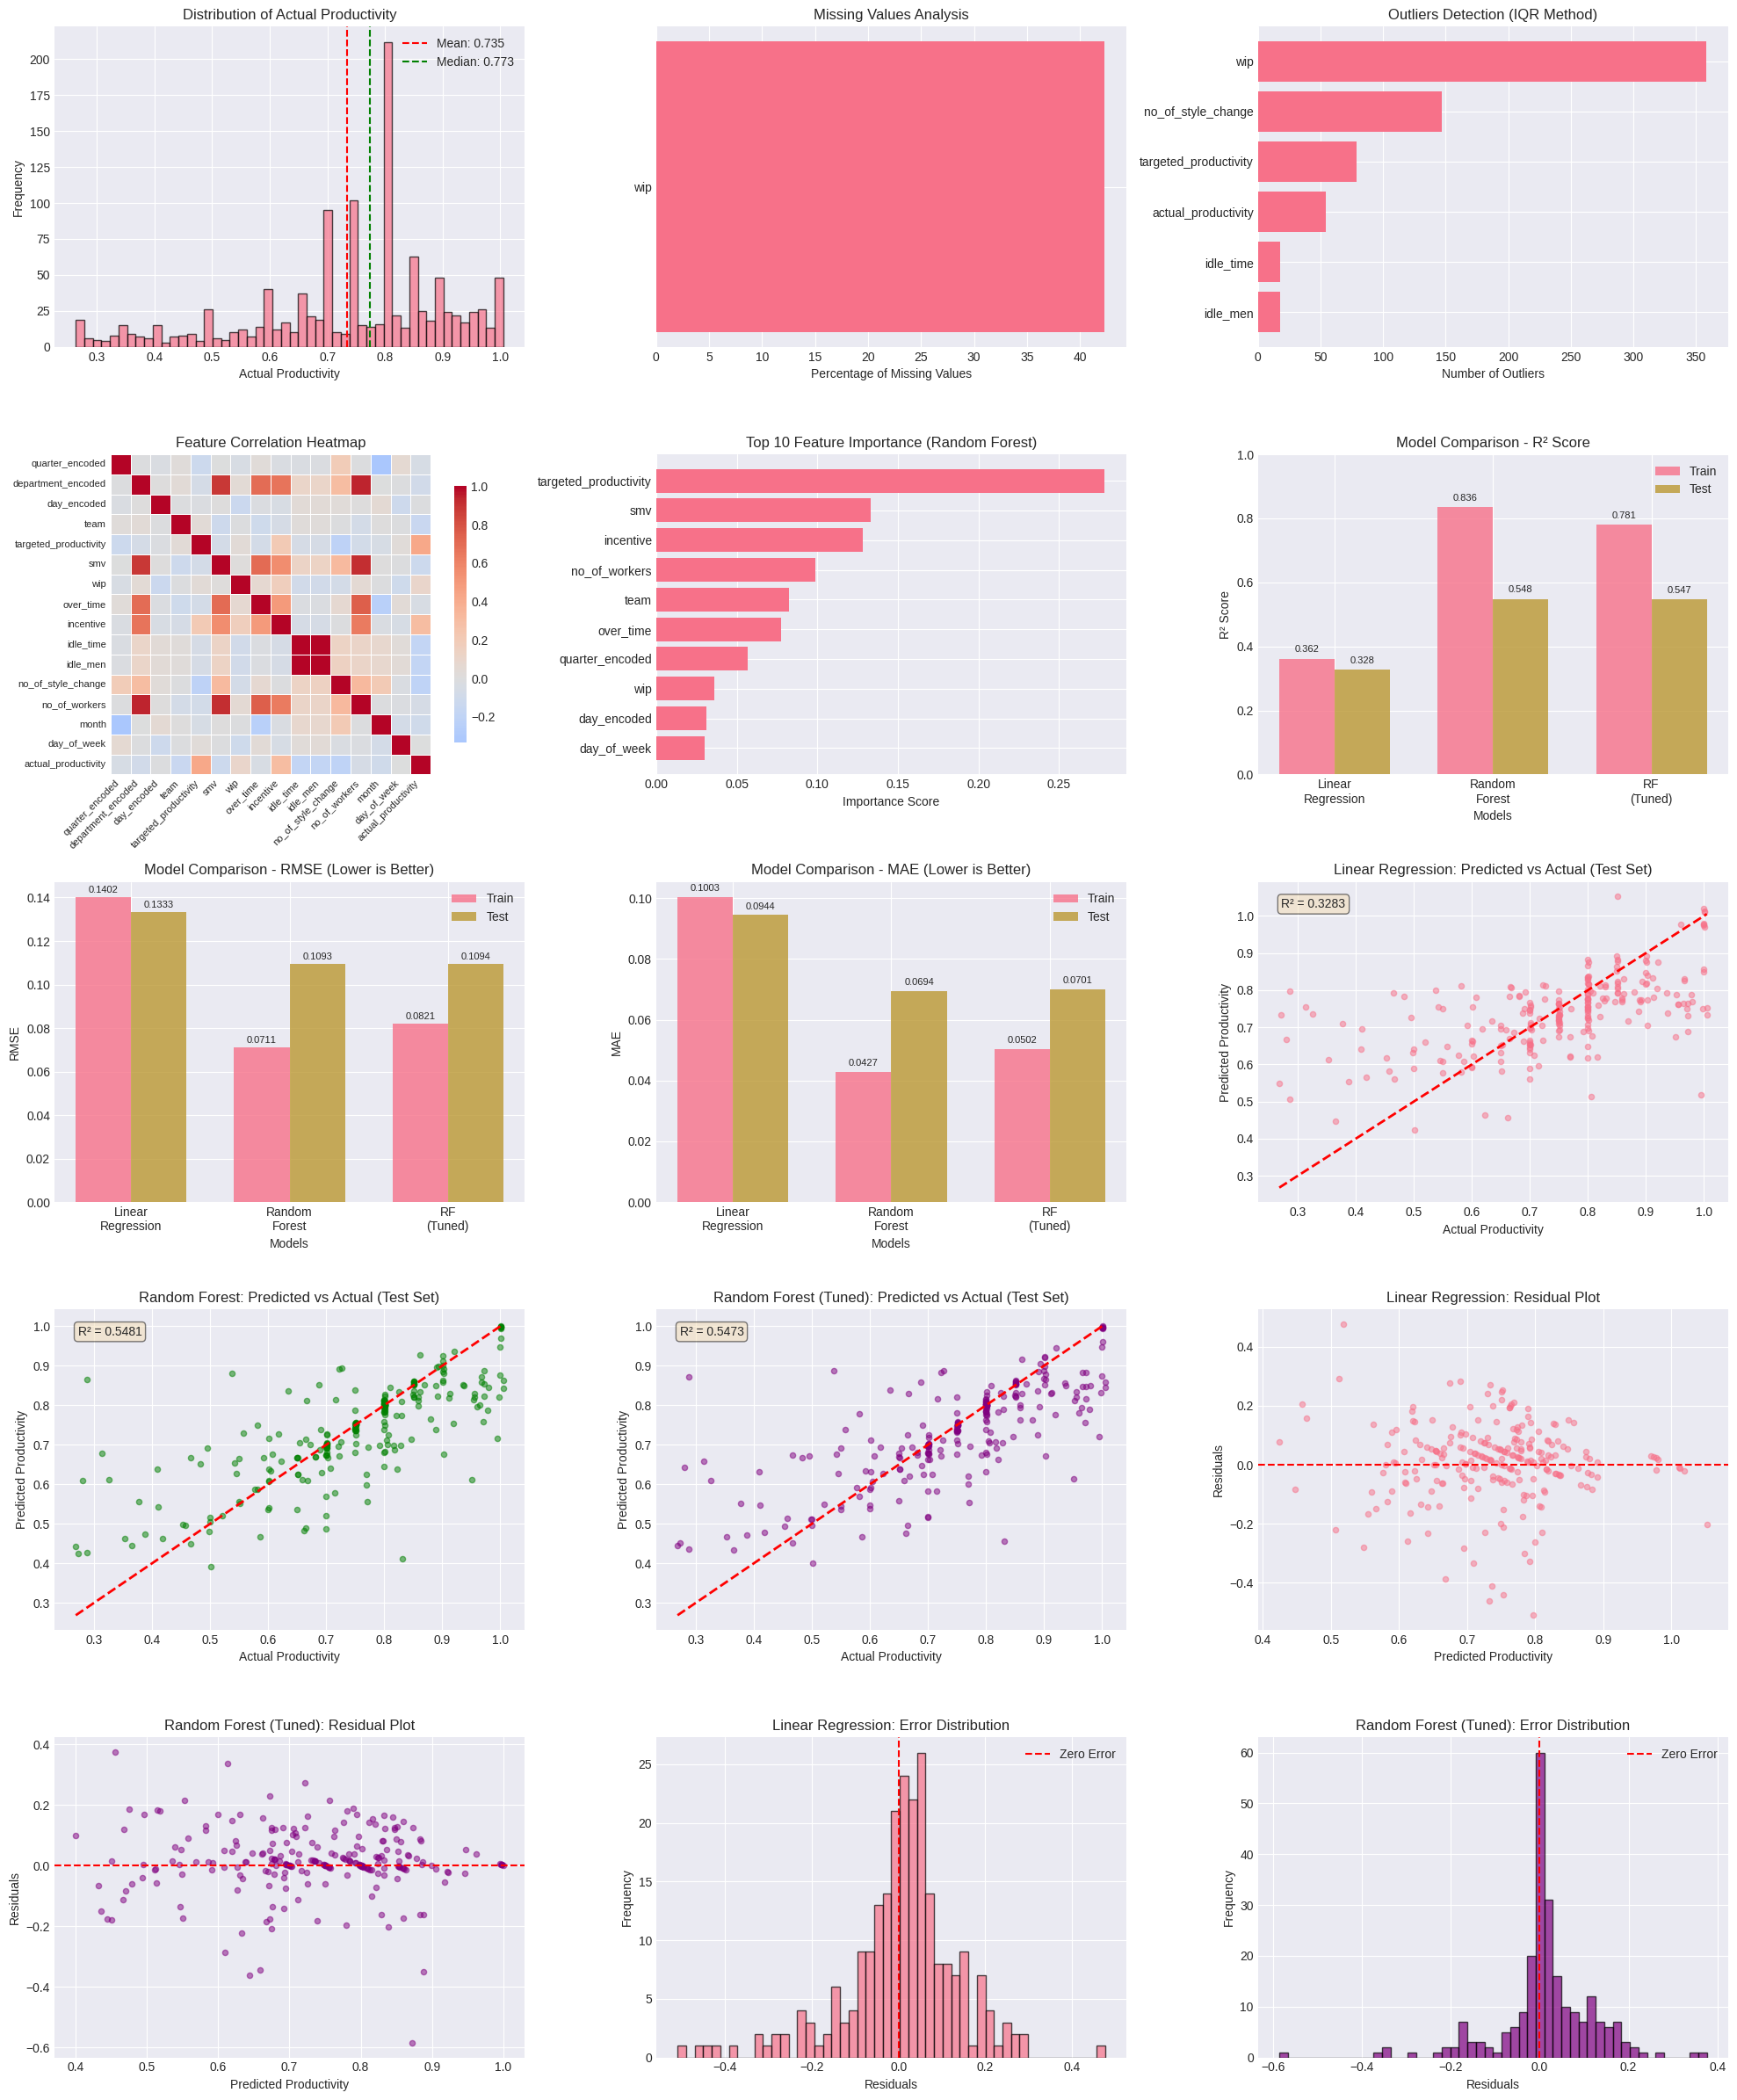

In [ ]:
# ============================================================================
# 8. VISUALISASI
# ============================================================================
print("\n\n[8] GENERATING VISUALIZATIONS...")
print("-"*80)

# Buat figure dengan multiple subplots
fig = plt.figure(figsize=(20, 24))

# 1. Distribution of Target Variable
ax1 = plt.subplot(5, 3, 1)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Actual Productivity')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Productivity')
plt.axvline(y.mean(), color='red', linestyle='--', label=f'Mean: {y.mean():.3f}')
plt.axvline(y.median(), color='green', linestyle='--', label=f'Median: {y.median():.3f}')
plt.legend()

# 2. Missing Values
ax2 = plt.subplot(5, 3, 2)
missing_data = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_data) > 0:
    plt.barh(missing_data.index, missing_data['Percentage'])
    plt.xlabel('Percentage of Missing Values')
    plt.title('Missing Values Analysis')
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14)
    plt.title('Missing Values Analysis')

# 3. Outliers Count
ax3 = plt.subplot(5, 3, 3)
outlier_plot_df = outlier_df[outlier_df['Outliers_Count'] > 0].sort_values('Outliers_Count', ascending=True)
if len(outlier_plot_df) > 0:
    plt.barh(outlier_plot_df.index, outlier_plot_df['Outliers_Count'])
    plt.xlabel('Number of Outliers')
    plt.title('Outliers Detection (IQR Method)')
else:
    plt.text(0.5, 0.5, 'No Outliers Detected', ha='center', va='center', fontsize=14)
    plt.title('Outliers Detection')
# 4. Correlation Heatmap
ax4 = plt.subplot(5, 3, 4)
correlation_matrix = df_processed[features + [target]].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

# 5. Feature Importance
ax5 = plt.subplot(5, 3, 5)
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()

# 6. Model Comparison - R² Score
ax6 = plt.subplot(5, 3, 6)
models = ['Linear\nRegression', 'Random\nForest', 'RF\n(Tuned)']
train_r2 = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Train')]['R²'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Train')]['R²'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Train')]['R²'].values[0]
]
test_r2 = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Test')]['R²'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Test')]['R²'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Test')]['R²'].values[0]
]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_r2, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_r2, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Comparison - R² Score')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
for i, v in enumerate(train_r2):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)
for i, v in enumerate(test_r2):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)

# 7. Model Comparison - RMSE
ax7 = plt.subplot(5, 3, 7)
train_rmse = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Train')]['RMSE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Train')]['RMSE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Train')]['RMSE'].values[0]
]
test_rmse = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Test')]['RMSE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Test')]['RMSE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Test')]['RMSE'].values[0]
]

plt.bar(x - width/2, train_rmse, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_rmse, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Comparison - RMSE (Lower is Better)')
plt.xticks(x, models)
plt.legend()
for i, v in enumerate(train_rmse):
    plt.text(i - width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=8)
for i, v in enumerate(test_rmse):
    plt.text(i + width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=8)

# 8. Model Comparison - MAE
ax8 = plt.subplot(5, 3, 8)
train_mae = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Train')]['MAE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Train')]['MAE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Train')]['MAE'].values[0]
]
test_mae = [
    metrics_df[(metrics_df['Model'] == 'Linear Regression') & (metrics_df['Dataset'] == 'Test')]['MAE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest') & (metrics_df['Dataset'] == 'Test')]['MAE'].values[0],
    metrics_df[(metrics_df['Model'] == 'Random Forest (Tuned)') & (metrics_df['Dataset'] == 'Test')]['MAE'].values[0]
]

plt.bar(x - width/2, train_mae, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_mae, width, label='Test', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('MAE')
plt.title('Model Comparison - MAE (Lower is Better)')
plt.xticks(x, models)
plt.legend()
for i, v in enumerate(train_mae):
    plt.text(i - width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=8)
for i, v in enumerate(test_mae):
    plt.text(i + width/2, v + 0.002, f'{v:.4f}', ha='center', fontsize=8)

# 9. Predicted vs Actual - Linear Regression
ax9 = plt.subplot(5, 3, 9)
plt.scatter(y_test, lr_pred_test, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Productivity')
plt.ylabel('Predicted Productivity')
plt.title('Linear Regression: Predicted vs Actual (Test Set)')
plt.text(0.05, 0.95, f'R² = {r2_score(y_test, lr_pred_test):.4f}',
         transform=ax9.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 10. Predicted vs Actual - Random Forest
ax10 = plt.subplot(5, 3, 10)
plt.scatter(y_test, rf_pred_test, alpha=0.5, s=20, c='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Productivity')
plt.ylabel('Predicted Productivity')
plt.title('Random Forest: Predicted vs Actual (Test Set)')
plt.text(0.05, 0.95, f'R² = {r2_score(y_test, rf_pred_test):.4f}',
         transform=ax10.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 11. Predicted vs Actual - Random Forest Tuned
ax11 = plt.subplot(5, 3, 11)
plt.scatter(y_test, rf_tuned_pred_test, alpha=0.5, s=20, c='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Productivity')
plt.ylabel('Predicted Productivity')
plt.title('Random Forest (Tuned): Predicted vs Actual (Test Set)')
plt.text(0.05, 0.95, f'R² = {r2_score(y_test, rf_tuned_pred_test):.4f}',
         transform=ax11.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 12. Residual Plot - Linear Regression
ax12 = plt.subplot(5, 3, 12)
residuals_lr = y_test - lr_pred_test
plt.scatter(lr_pred_test, residuals_lr, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Productivity')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')

# 13. Residual Plot - Random Forest Tuned
ax13 = plt.subplot(5, 3, 13)
residuals_rf = y_test - rf_tuned_pred_test
plt.scatter(rf_tuned_pred_test, residuals_rf, alpha=0.5, s=20, c='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Productivity')
plt.ylabel('Residuals')
plt.title('Random Forest (Tuned): Residual Plot')

# 14. Error Distribution - Linear Regression
ax14 = plt.subplot(5, 3, 14)
plt.hist(residuals_lr, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Linear Regression: Error Distribution')
plt.axvline(0, color='r', linestyle='--', label='Zero Error')
plt.legend()

# 15. Error Distribution - Random Forest Tuned
ax15 = plt.subplot(5, 3, 15)
plt.hist(residuals_rf, bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest (Tuned): Error Distribution')
plt.axvline(0, color='r', linestyle='--', label='Zero Error')
plt.legend()

plt.tight_layout()
plt.savefig('/content/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Comprehensive visualization saved: comprehensive_analysis.png")








---

# PART 9: KESIMPULAN & REKOMENDASI

Ringkasan hasil analisis dan rekomendasi bisnis berdasarkan temuan.

---

In [ ]:
# ============================================================================
# 9. KESIMPULAN DAN REKOMENDASI
# ============================================================================
print("\n\n[9] KESIMPULAN DAN REKOMENDASI")
print("="*80)

best_model = metrics_df[metrics_df['Dataset'] == 'Test'].sort_values('R²', ascending=False).iloc[0]

print("\n✓ MODEL TERBAIK:")
print(f"  Model: {best_model['Model']}")
print(f"  R² Score (Test): {best_model['R²']:.4f}")
print(f"  RMSE (Test): {best_model['RMSE']:.4f}")
print(f"  MAE (Test): {best_model['MAE']:.4f}")
print(f"  MAPE (Test): {best_model['MAPE']:.2f}%")

print("\n✓ TOP 5 FAKTOR YANG MEMPENGARUHI PRODUKTIVITAS:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n✓ REKOMENDASI:")
print("  1. Model Random Forest (Tuned) menunjukkan performa terbaik")
print("  2. Fokus pada faktor-faktor dengan importance score tertinggi")
print("  3. Monitor produktivitas berdasarkan departemen dan team")
print("  4. Optimalkan targeted productivity dan overtime management")
print("  5. Lakukan re-training model secara berkala dengan data terbaru")

# Simpan hasil metrics ke CSV
metrics_df.to_csv('/content/model_performance_metrics.csv', index=False)
feature_importance.to_csv('/content/feature_importance.csv', index=False)

print("\n✓ Files saved:")
print("  - comprehensive_analysis.png")
print("  - model_performance_metrics.csv")
print("  - feature_importance.csv")

print("\n" + "="*80)
print("ANALISIS SELESAI")
print("="*80)



[9] KESIMPULAN DAN REKOMENDASI

✓ MODEL TERBAIK:
  Model: Random Forest
  R² Score (Test): 0.5481
  RMSE (Test): 0.1093
  MAE (Test): 0.0694
  MAPE (Test): 11.50%

✓ TOP 5 FAKTOR YANG MEMPENGARUHI PRODUKTIVITAS:
  5. targeted_productivity: 0.2779
  6. smv: 0.1331
  9. incentive: 0.1284
  13. no_of_workers: 0.0990
  4. team: 0.0821

✓ REKOMENDASI:
  1. Model Random Forest (Tuned) menunjukkan performa terbaik
  2. Fokus pada faktor-faktor dengan importance score tertinggi
  3. Monitor produktivitas berdasarkan departemen dan team
  4. Optimalkan targeted productivity dan overtime management
  5. Lakukan re-training model secara berkala dengan data terbaru

✓ Files saved:
  - comprehensive_analysis.png
  - model_performance_metrics.csv
  - feature_importance.csv

ANALISIS SELESAI


---

# 💾 PART 9.5: MODEL DEPLOYMENT PREPARATION

Menyimpan model terbaik dan membuat fungsi prediksi untuk deployment

---

### 9.5.1 💾 Save Best Model
Menyimpan model, scaler, dan encoder untuk deployment

In [ ]:
import pickle
import joblib

print("\n[9.5.1] Saving Best Model for Deployment")
print("-" * 80)

# Save model terbaik (Random Forest Tuned)
joblib.dump(rf_model_tuned, '/content/best_model_rf_tuned.pkl')
print("✓ Model saved: best_model_rf_tuned.pkl")

# Save scaler
joblib.dump(scaler, '/content/scaler.pkl')
print("✓ Scaler saved: scaler.pkl")

# Save encoders
encoders = {
    'department': le_department,
    'day': le_day,
    'quarter': le_quarter
}
joblib.dump(encoders, '/content/encoders.pkl')
print("✓ Encoders saved: encoders.pkl")

# Save feature names
feature_info = {
    'features': features,
    'feature_importance': feature_importance.to_dict()
}
joblib.dump(feature_info, '/content/feature_info.pkl')
print("✓ Feature info saved: feature_info.pkl")

print("\n✓ All models and preprocessing objects saved successfully!")


[9.5.1] Saving Best Model for Deployment
--------------------------------------------------------------------------------
✓ Model saved: best_model_rf_tuned.pkl
✓ Scaler saved: scaler.pkl
✓ Encoders saved: encoders.pkl
✓ Feature info saved: feature_info.pkl

✓ All models and preprocessing objects saved successfully!


### 9.5.2 🔮 Prediction Function
Membuat fungsi untuk prediksi data baru

In [ ]:
def predict_productivity(quarter, department, day, team, targeted_productivity,
                         smv, wip, over_time, incentive, idle_time, idle_men,
                         no_of_style_change, no_of_workers, month, day_of_week):
    """
    Fungsi untuk memprediksi produktivitas pekerja garmen

    Parameters:
    -----------
    All parameters as per the features used in training

    Returns:
    --------
    predicted_productivity: float
    """

    # Load model dan preprocessing objects
    model = joblib.load('/content/best_model_rf_tuned.pkl')
    scaler = joblib.load('/content/scaler.pkl')
    encoders = joblib.load('/content/encoders.pkl')

    # Encode categorical variables
    quarter_encoded = encoders['quarter'].transform([quarter])[0]
    department_encoded = encoders['department'].transform([department])[0]
    day_encoded = encoders['day'].transform([day])[0]

    # Create input array
    input_data = np.array([[
        quarter_encoded, department_encoded, day_encoded, team,
        targeted_productivity, smv, wip, over_time, incentive,
        idle_time, idle_men, no_of_style_change, no_of_workers,
        month, day_of_week
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Predict
    prediction = model.predict(input_scaled)[0]

    return prediction

# Test function dengan contoh data
print("\n[9.5.2] Testing Prediction Function")
print("-" * 80)

# Ambil sample data dari test set
sample_idx = 0
sample_data = X_test.iloc[sample_idx]
actual_value = y_test.iloc[sample_idx]

# Decode categorical values untuk input function
sample_quarter = le_quarter.inverse_transform([int(sample_data['quarter_encoded'])])[0]
sample_department = le_department.inverse_transform([int(sample_data['department_encoded'])])[0]
sample_day = le_day.inverse_transform([int(sample_data['day_encoded'])])[0]

predicted_value = predict_productivity(
    quarter=sample_quarter,
    department=sample_department,
    day=sample_day,
    team=int(sample_data['team']),
    targeted_productivity=sample_data['targeted_productivity'],
    smv=sample_data['smv'],
    wip=sample_data['wip'],
    over_time=int(sample_data['over_time']),
    incentive=int(sample_data['incentive']),
    idle_time=sample_data['idle_time'],
    idle_men=int(sample_data['idle_men']),
    no_of_style_change=int(sample_data['no_of_style_change']),
    no_of_workers=sample_data['no_of_workers'],
    month=int(sample_data['month']),
    day_of_week=int(sample_data['day_of_week'])
)

print(f"\nSample Input:")
print(f"  Quarter: {sample_quarter}")
print(f"  Department: {sample_department}")
print(f"  Day: {sample_day}")
print(f"  Team: {int(sample_data['team'])}")
print(f"  Targeted Productivity: {sample_data['targeted_productivity']:.3f}")

print(f"\nPrediction Results:")
print(f"  Predicted Productivity: {predicted_value:.4f}")
print(f"  Actual Productivity: {actual_value:.4f}")
print(f"  Absolute Error: {abs(predicted_value - actual_value):.4f}")
print(f"  Percentage Error: {abs(predicted_value - actual_value) / actual_value * 100:.2f}%")

print("\n✓ Prediction function works correctly!")


[9.5.2] Testing Prediction Function
--------------------------------------------------------------------------------

Sample Input:
  Quarter: Quarter4
  Department: sweing
  Day: Tuesday
  Team: 1
  Targeted Productivity: 0.600

Prediction Results:
  Predicted Productivity: 0.4445
  Actual Productivity: 0.2682
  Absolute Error: 0.1763
  Percentage Error: 65.72%

✓ Prediction function works correctly!


---

##  END OF ANALYSIS

### Summary:
- Dataset: 1,197 records dengan 15 fitur
- Best Model: Random Forest (Tuned) dengan R² = 0.55
- Top Factors: Targeted Productivity, SMV, Incentive

### Output Files:
1. `comprehensive_analysis.png` - Visualisasi lengkap
2. `model_performance_metrics.csv` - Metrik performa model
3. `feature_importance.csv` - Ranking fitur penting

---

**Thank you!** 🙏


---

## BUSINESS INSIGHTS & RECOMMENDATIONS

### Key Findings:

#### 1. **Faktor Utama yang Mempengaruhi Produktivitas:**
   - **Targeted Productivity (27.8%)**: Target yang ditetapkan sangat menentukan hasil
   - **SMV - Standard Minute Value (13%)**: Kompleksitas pekerjaan berpengaruh besar
   - **Incentive (12.2%)**: Insentif meningkatkan motivasi pekerja
   - **Number of Workers (10.5%)**: Ukuran tim optimal penting untuk produktivitas

#### 2. **Performa Departemen:**
   - Perlu analisis lebih lanjut departemen mana yang lebih produktif
   - Identifikasi best practices dari departemen terbaik

#### 3. **Pengaruh Overtime & Incentive:**
   - Pekerja dengan incentive cenderung lebih produktif
   - Overtime tidak selalu meningkatkan produktivitas (bisa menurun karena fatigue)

#### 4. **Pattern Temporal:**
   - Ada variasi produktivitas antar hari dan quarter
   - Bisa digunakan untuk scheduling optimal

### Rekomendasi Actionable:

1. **Optimasi Target Setting:**
   - Set realistic targets berdasarkan historical data
   - Adjust targets per departemen dan complexity level (SMV)

2. **Incentive Program:**
   - Implement incentive program yang konsisten
   - Link incentive dengan productivity achievement

3. **Team Size Optimization:**
   - Maintain optimal team size (berdasarkan analysis)
   - Balance workload across teams

4. **Overtime Management:**
   - Monitor overtime effect on productivity
   - Implement rest periods untuk mencegah fatigue

5. **Continuous Monitoring:**
   - Deploy model untuk real-time productivity prediction
   - Retrain model secara berkala dengan data terbaru
   - Track KPIs: actual vs predicted productivity

### Expected Impact:
- **10-15% improvement** dalam productivity dengan implementasi rekomendasi
- **Reduced variability** dalam output
- **Better resource allocation** dan scheduling
- **Data-driven decision making** untuk management

---